<a href="https://colab.research.google.com/github/ccg-esb-lab/BAFFLE/blob/master/py_pOXA48_SI4_pairwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Pair-wise competition experiments

In [19]:
import numpy as np
import os
import csv
import sys
import matplotlib.pyplot as plt
import colorcet as cc
import time
import multiprocessing
import random
from tabulate import tabulate

In [20]:

# Define your paths
root='/content/drive/MyDrive/SYNC_Projects/pOXA48/2023/code/py-files/'

path='./'
figPath = path+'figures/'
envPath = path+'env/'
dataPath = path+'data/'

strains_subsetE = [1, 2, 6, 9, 11, 15, 18, 20, 21, 24]
strains_subsetK = [25, 26, 29, 34, 37, 38, 39, 41, 43, 45]

strains_subset = strains_subsetE + strains_subsetK

print("subset: ",strains_subset)

strains = ['C001', 'C002',  'C006',  'C011',  'C012',  'C021',  'C022',  'C031',  'C051',  'C063',  'C094',  'C107',  'C115',  'C131',  'C141',  'C201',  'C227',  'C232',  'C247',  'C261',  'C286',  'C290',  'C302',  'C309',  'C324',  'K037',  'K038',  'K087',  'K094',  'K112',  'K114',  'K125',  'K141',  'K168',  'K177',  'K200',  'K201',  'K209',  'K213',  'K216',  'K224',  'K225',  'K241',  'K248',  'K249',  'K253',  'K257',  'K275',  'K285',  'K300']
plasmids = ['WT','TC']

tot_strains = int(len(strains))
cmap_strains = cc.glasbey_light[:tot_strains]


subset:  [1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]


In [21]:

from google.colab import drive
drive.mount('/content/drive')


os.chdir(root)
sys.path.insert(0, 'src/')
from pOXA48_S1 import *
from pOXA48_S2 import *
from pOXA48_S3 import *



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model parameters

In [4]:

B0 = 1e6 #Initial bacterial density
T = 24 #Duration of experimental season
S0 = 1 #Concentration of imiting resource
extinction_threshold=1 #Extinction threshold
alphas=[1e-10, 1e-12] #Antibiotic degradation rate
d=0.1 #Transfer dilution rate

A_max=65536*2 #Maximum antibiotic concentrations=[32768, 256, 1024, 32]

expe_params = {
    'B0': B0, #Initial bacterial density
    'A_max': A_max, #Maximum drug concentration
    'alphas': np.array(alphas), #Antibiotic degradation rate
    'T': T,  # Length of experiment
    'S0': S0,  # Resource concentration
    'd': d,  # Resource concentration
    'extinction_threshold': extinction_threshold,
}


## Load experimental parameters from files
(MCMC & Resistance & Conjugation permissiveness & MIC)

In [5]:
model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)

display_model_params_stats(model_params)

╒═════════╤═════════════╤═══════════════════════╤════════════════════════════════════════════╤═════╕
│ Group   │ Parameter   │ Mean                  │ Range                                      │ N   │
╞═════════╪═════════════╪═══════════════════════╪════════════════════════════════════════════╪═════╡
│ E-TC    │ conj_rate   │ nan                   │ (nan, nan)                                 │ 25  │
├─────────┼─────────────┼───────────────────────┼────────────────────────────────────────────┼─────┤
│ E-TC    │ VKm         │ 6.3164e-10            │ (3.79e-10, 8.37e-10)                       │ 25  │
├─────────┼─────────────┼───────────────────────┼────────────────────────────────────────────┼─────┤
│ E-TC    │ rho         │ 842358780.8           │ (506376720.0, 1071282240.0)                │ 25  │
├─────────┼─────────────┼───────────────────────┼────────────────────────────────────────────┼─────┤
│ E-TC    │ seg_rate    │ 0.7843146083017115    │ (0.41282435738322215, 1.5263650048538724)

### Load random environments

In [6]:
num_days = 10
str_E = 'gaussian_noise'
iEs = [0, 1, 2, 4]
Es=load_environments(str_E, envPath, num_days, iEs)

## Computer simulations: Pair-wise competition experiments

In [22]:
def run_pairwiseCompetition(model_params, strains1, strains2, Es):
    S0 = model_params.attrs['S0']
    B0 = model_params.attrs['B0']

    # A data structure to store results
    results = {}

    for iE, E in enumerate(Es):
        #print("%s: %s"%(iE, E))
        results_E = []

        for i, strain1 in enumerate(strains1):
            print('Es[%s]: %s vs %s '%(iE, strain1, strains2))
            for j, strain2 in enumerate(strains2):
                istrains_values = [strain1, strain2]

                times_list, ys_list, strains_params_list = simulateTransfers_multistrain(model_params, istrains_values, E)
                final_times, final_ys = get_final_points(times_list, ys_list)

                final_densities = final_ys[-1][2:]
                results_E.append((final_densities, strain1, strain2))

        # Store results for this E
        results[iE] = results_E  # use string representation of E as key

    return results




In [8]:
istrains = strains_subset  # List of strains

iE=0 #which environment
numDays=10

Amax_values = [0, 2**4, 2**8, 2**12, 2**16, 2**20]
E_values=[]
for Amax in Amax_values:

  #E=Amax*np.ones(numDays) #Constant environment
  E = Amax*Es[iE]  # Random Environment

  E_values.append(E)

Here we run simulation:

In [23]:
#numDays=1
#Amax_values = [0, 2**4, 2**8, 2**12, 2**16]
#Es = []
#for Amax in Amax_values:
#  E=Amax*np.ones(numDays) #Constant environment
#  #E = Amax*Es[iE]  # Random Environment
#  Es.append(E)


sim_df=run_pairwiseCompetition(model_params, strains_subsetE, strains_subsetK, E_values)
max_density = 1e9


0: 1 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
0: 2 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
0: 6 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
0: 9 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
0: 11 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
0: 15 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
0: 18 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
0: 20 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
0: 21 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
0: 24 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 1 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 2 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 6 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 9 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 11 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 15 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 18 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 20 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 21 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
1: 24 vs [25, 26, 29, 34, 37, 38, 39, 4

In [24]:
strain_namesK = [model_params['strain_name'][i] for i in strains_subsetK]
strain_namesE = [model_params['strain_name'][j] for j in strains_subsetE]

print("K: %s"%(strain_namesK))
print("E: %s"%(strain_namesE))

K: ['PF_KPN01', 'PF_KPN02', 'PF_KQ01', 'PF_KPN09', 'PF_KPN10', 'PF_KPN11', 'PF_KQ04', 'PF_KPN12', 'PF_KPN14', 'PF_KPN16']
E: ['PF_EC02', 'PF_EC03', 'PF_EC07', 'PF_EC10', 'PF_EC12', 'PF_EC16', 'PF_EC19', 'PF_EC21', 'PF_EC22', 'PF_EC25']


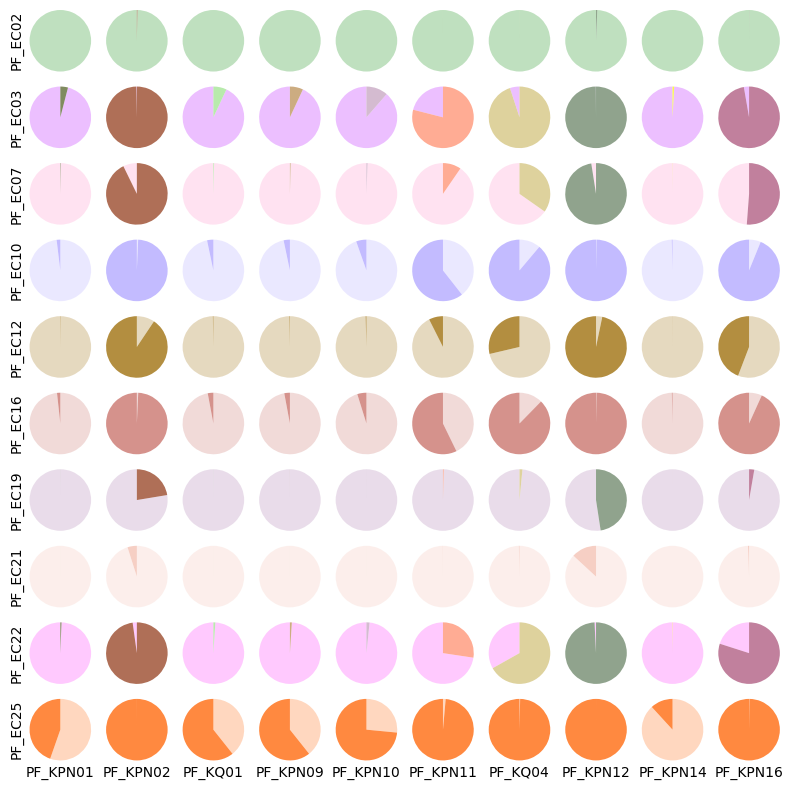

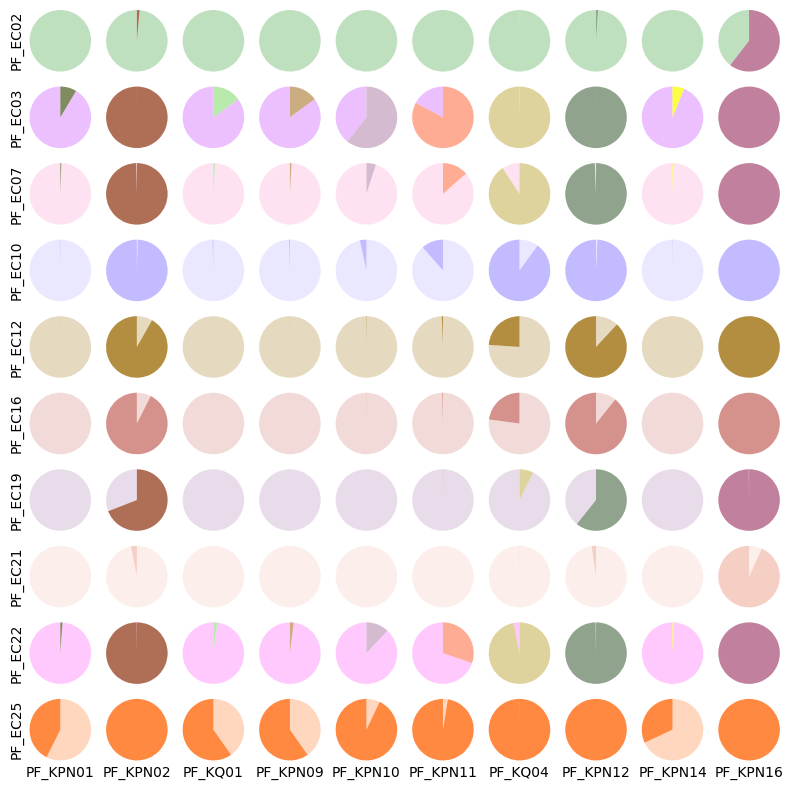

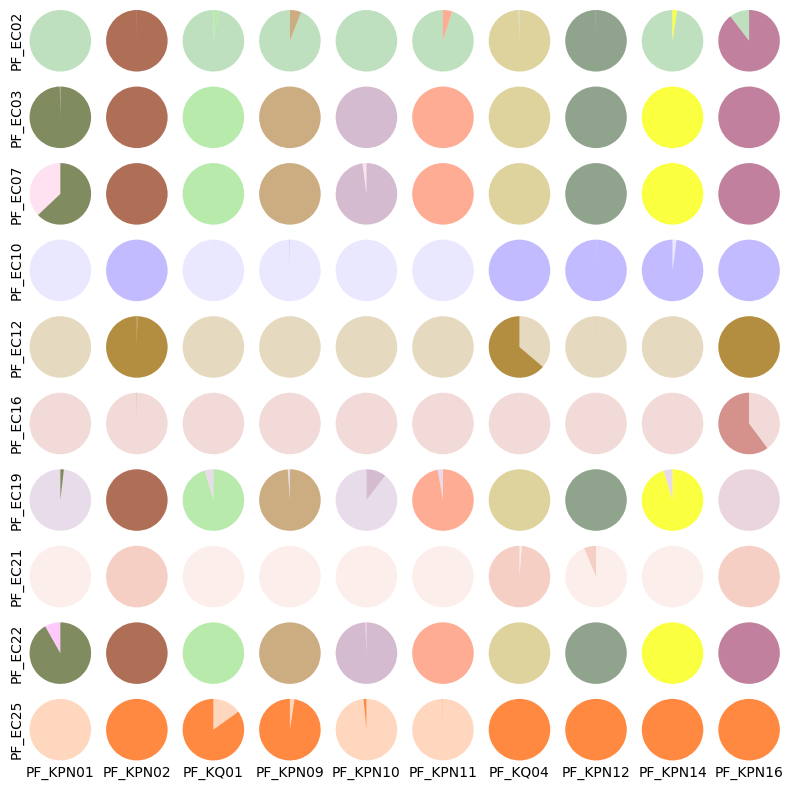

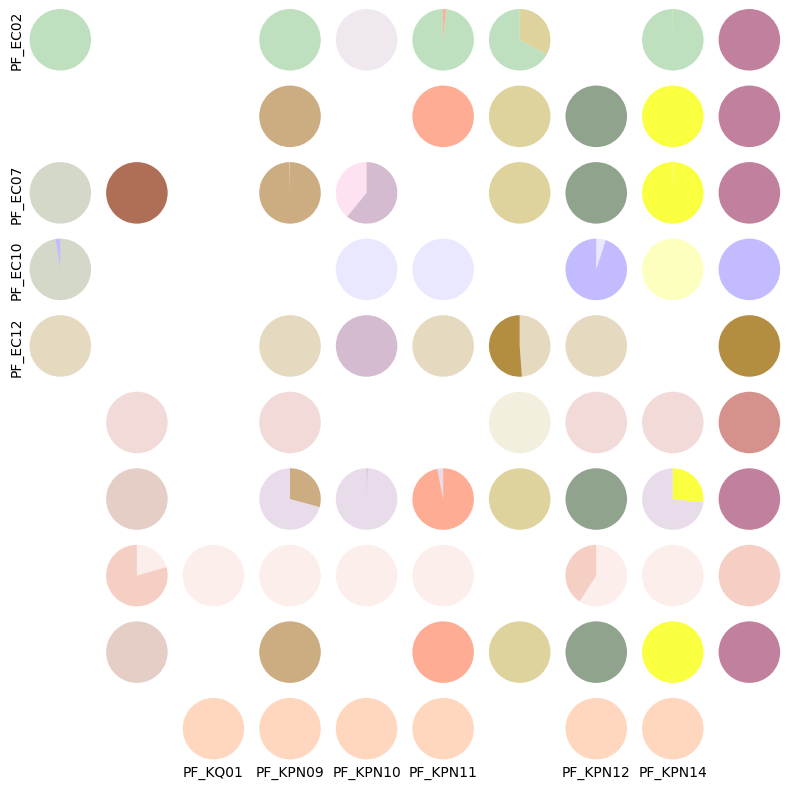

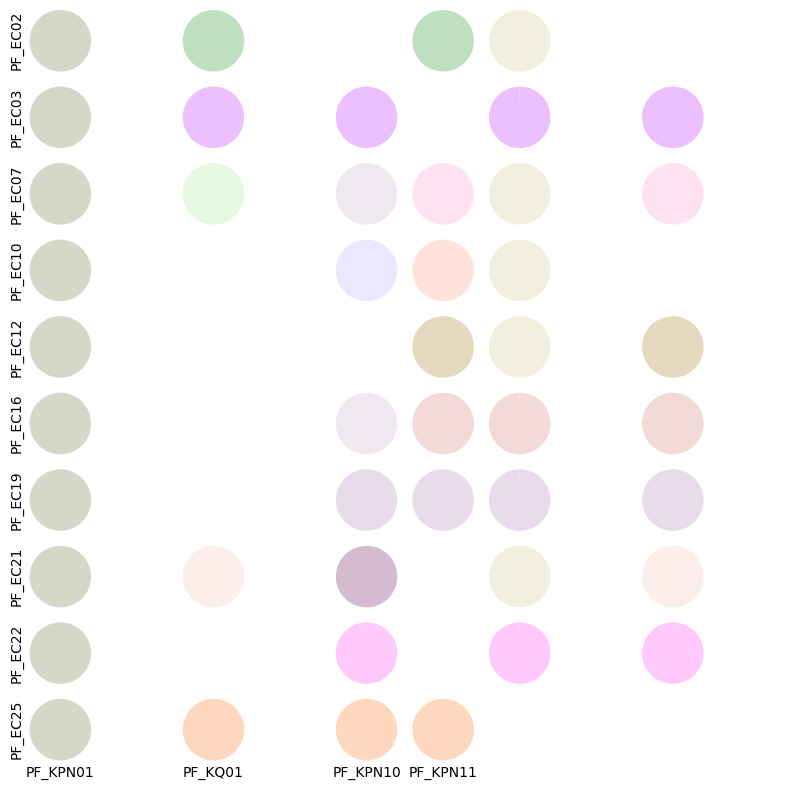

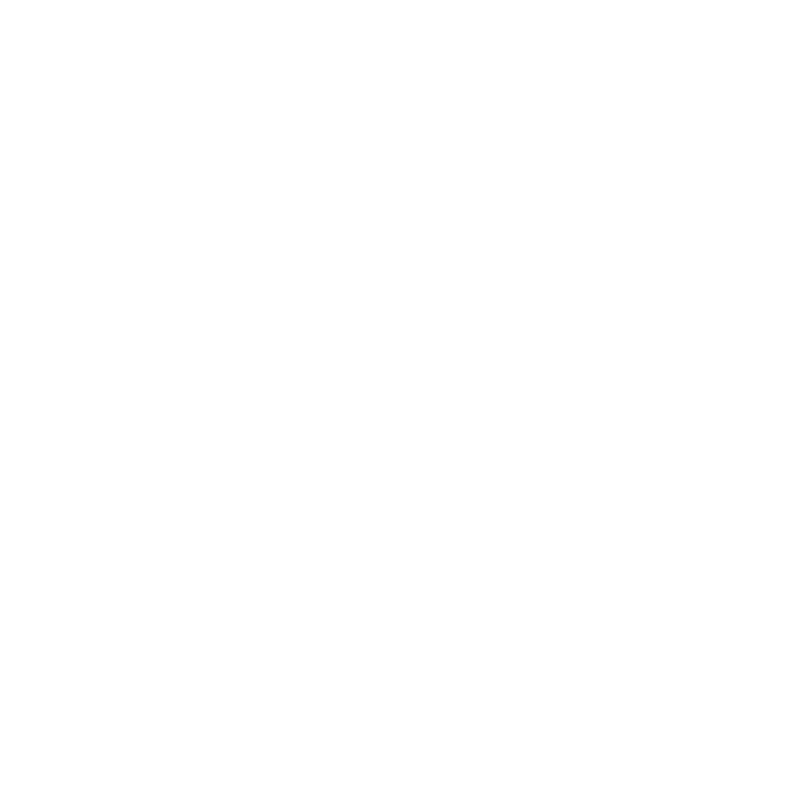

In [26]:
def plot_popStructure_strains(densities, max_density, colors, ax):
    num_subpopulations = len(densities)

    # Convert negative densities to zero
    densities = np.maximum(densities, 0)

    # Calculate relative abundances for each subpopulation
    total_density = sum(densities)
    # If total_density is not zero, compute relative_abundances
    if total_density != 0:
        relative_abundances = [density / total_density for density in densities]
    else:
        # Handle the case where total_density is zero
        # You might want to replace this with an appropriate fallback or error message
        relative_abundances = [0 for density in densities]

    # Calculate the radius based on the sum of densities
    #radius = total_density/ max_density
    # Add a small constant to prevent log(0)
    small_constant = 1e-10

    # Compute radius
    radius = (total_density + small_constant)
    #radius = np.log10(total_density + small_constant) / np.log10(max_density + small_constant)
    if radius>1:
      radius=1

    if radius< small_constant:
      radius= small_constant

    alphas = [0.75 if i % 2 == 0 else 0.25 for i in range(num_subpopulations)]

    #print("r=",radius)

    # Create the pie chart
    wedges, _ = ax.pie(relative_abundances, colors=colors, radius=radius, startangle=90)

    # Set alpha for each wedgecc
    for i, (wedge, alpha_val) in enumerate(zip(wedges, alphas)):
        wedge.set_alpha(alpha_val)

    # Set aspect ratio to be equal so that the pie is circular
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    #ax.axis('equal')


for iE, results_E in sim_df.items():
    #print("Amax=%s"%Es[iE])
    fig, axs = plt.subplots(len(strains_subsetE), len(strains_subsetK), figsize=(8,8), sharey=True, sharex=True)

    for result in results_E:
        final_densities, strain1, strain2 = result

        i = strains_subsetE.index(strain1)
        j = strains_subsetK.index(strain2)
        ax = axs[i, j]

        color_strains=[cmap_strains[strain1], cmap_strains[strain1], cmap_strains[strain2], cmap_strains[strain2]]
        if np.sum(final_densities)>expe_params['extinction_threshold']:
          plot_popStructure_strains(final_densities, max_density, color_strains, ax)
        else:
          ax.axis('off')

        if i==len(strains_subsetK)-1:
          ax.set_xlabel(strain_namesK[j])
        if j==0:
          ax.set_ylabel(strain_namesE[i])


    plt.tight_layout()
    plt.show()



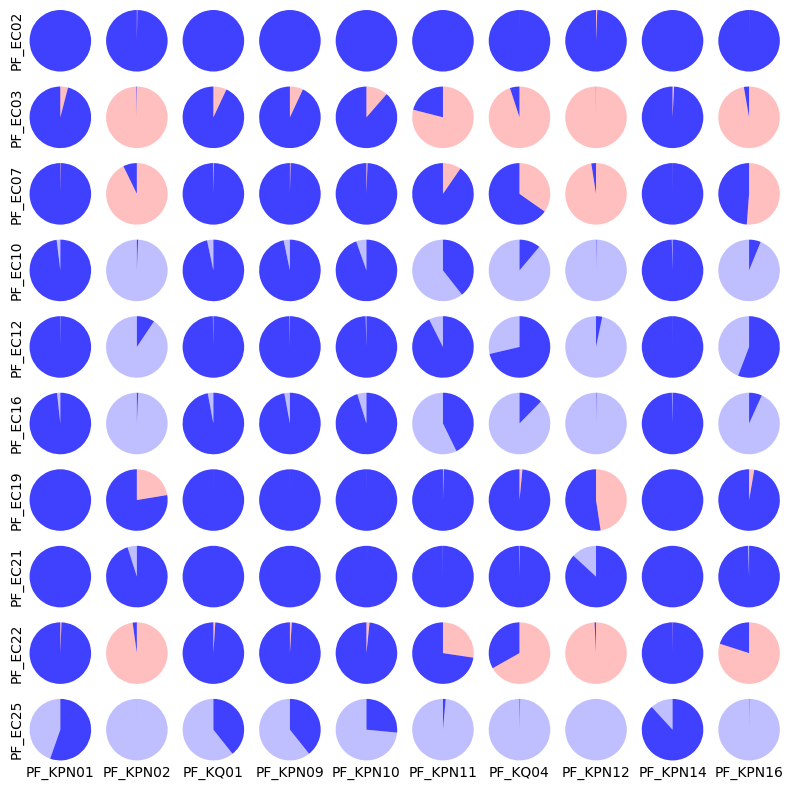

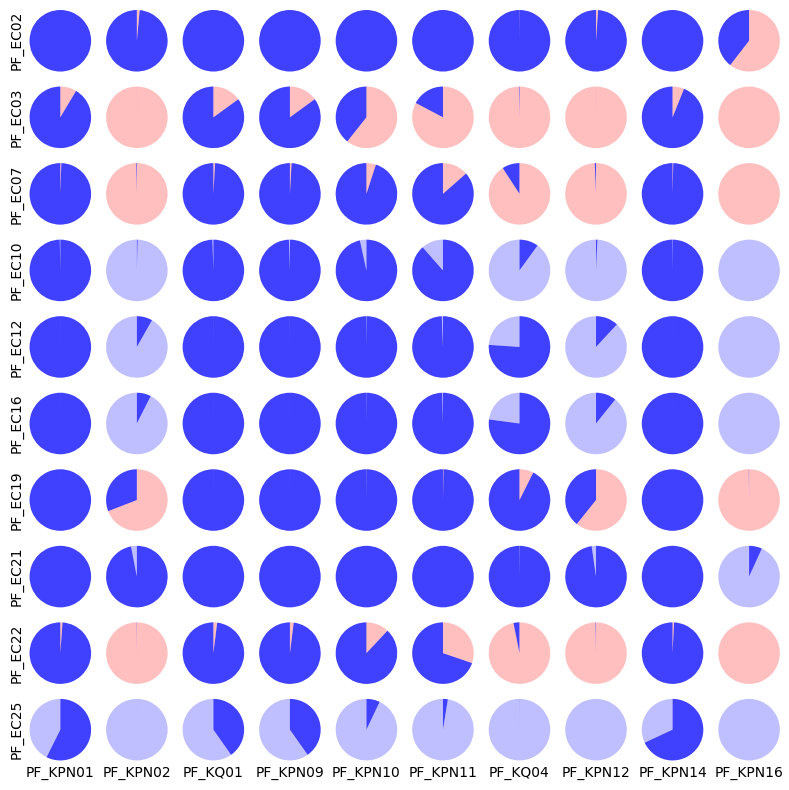

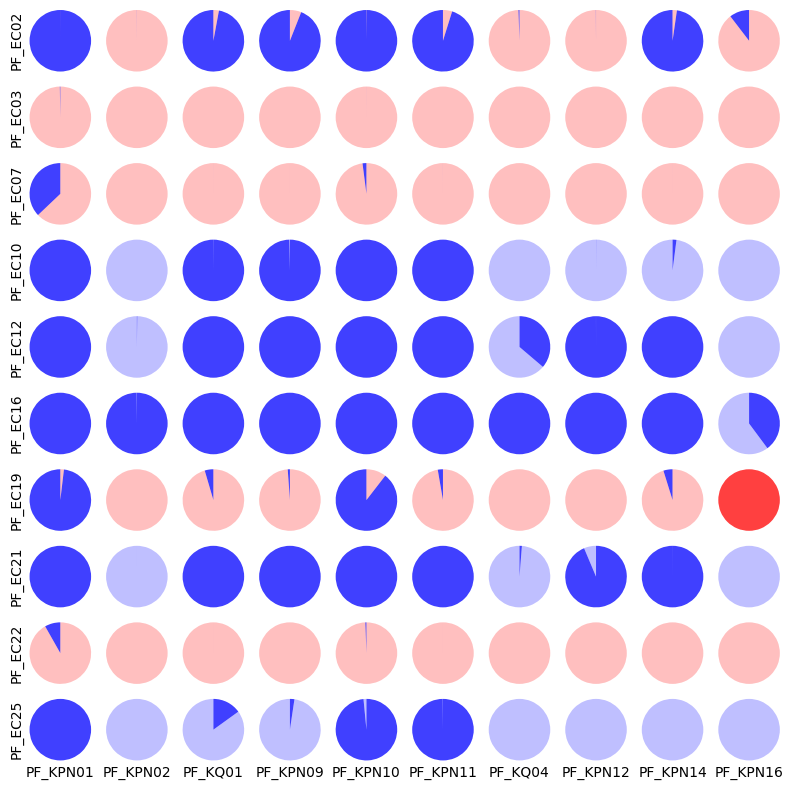

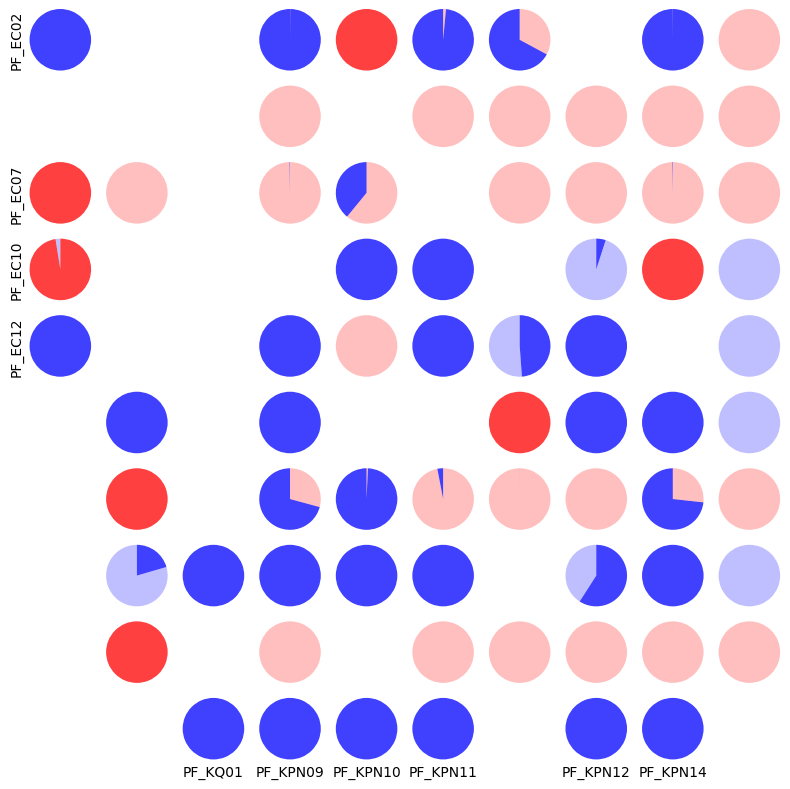

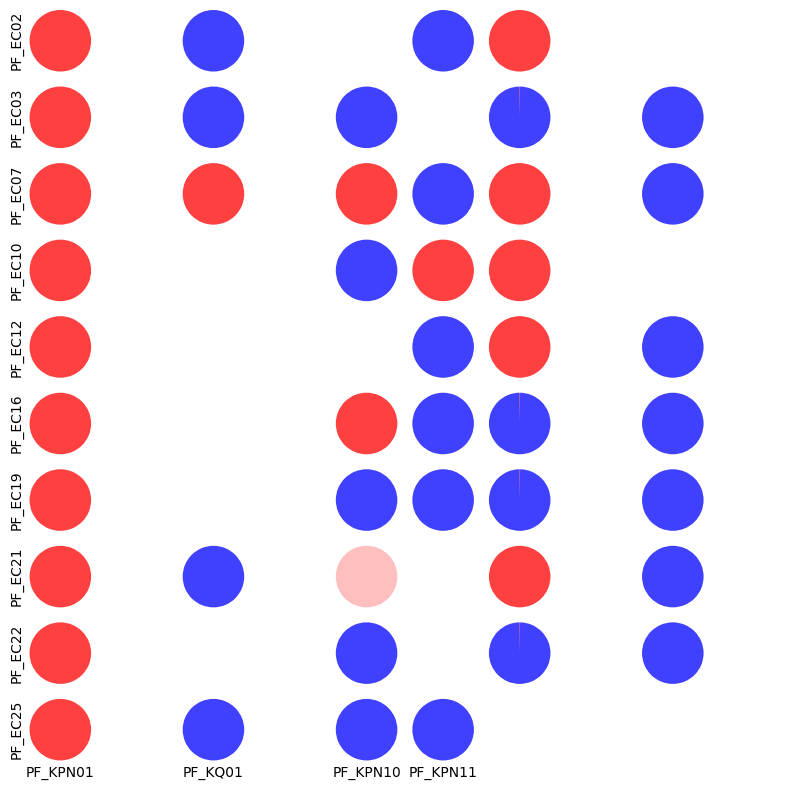

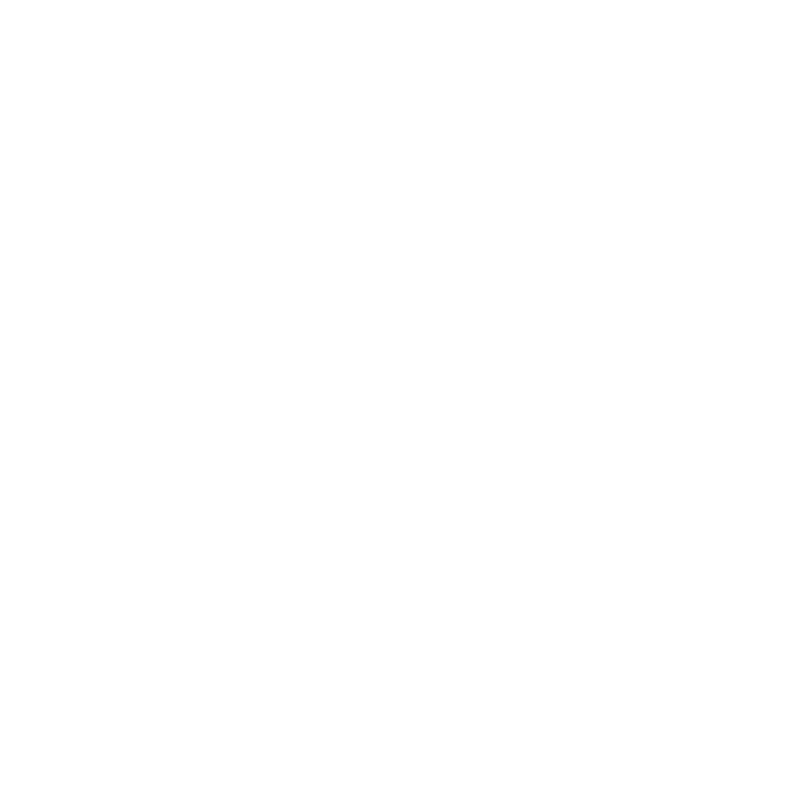

In [27]:
def plot_popStructure_species(densities, max_density, colors, ax):
    num_subpopulations = len(densities)

    # Convert negative densities to zero
    densities = np.maximum(densities, 0)

    # Calculate relative abundances for each subpopulation
    total_density = sum(densities)
    # If total_density is not zero, compute relative_abundances
    if total_density != 0:
        relative_abundances = [density / total_density for density in densities]
    else:
        # Handle the case where total_density is zero
        # You might want to replace this with an appropriate fallback or error message
        relative_abundances = [0 for density in densities]

    # Calculate the radius based on the sum of densities
    small_constant = 1e-10

    # Compute radius
    radius = total_density + small_constant
    #radius = np.log10(total_density + small_constant) / np.log10(max_density + small_constant)
    if radius>1:
      radius=1

    if radius< small_constant:
      radius= small_constant

    alphas = [0.25 if i % 2 == 0 else 0.75 for i in range(num_subpopulations)]

    # Create the pie chart
    wedges, _ = ax.pie(relative_abundances, colors=colors, radius=radius, startangle=90)

    # Set alpha for each wedge
    for i, (wedge, alpha_val) in enumerate(zip(wedges, alphas)):
        wedge.set_alpha(alpha_val)

    # Set aspect ratio to be equal so that the pie is circular
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])


for iE, results_E in sim_df.items():
    fig, axs = plt.subplots(len(strains_subsetE), len(strains_subsetK), figsize=(8,8))

    for result in results_E:
        final_densities, strain1, strain2 = result

        i = strains_subsetE.index(strain1)
        j = strains_subsetK.index(strain2)
        ax = axs[i, j]

        # Assign colors based on strain type
        color_strains = ['blue', 'blue', 'red', 'red']
        if np.sum(final_densities)>expe_params['extinction_threshold']:
          plot_popStructure_species(final_densities, max_density, color_strains, ax)
        else:
          ax.axis('off')

        if i==len(strains_subsetK)-1:
          ax.set_xlabel(strain_namesK[j])
        if j==0:
          ax.set_ylabel(strain_namesE[i])
    plt.tight_layout()
    plt.show()


In [ ]:
#sim_df.to_csv('simulation_results.csv', index=False)


In [28]:
def compute_pairwiseStability(sim_df, strains_subset, Es):
    extinction_threshold = expe_params['extinction_threshold']
    percentages0 = []
    percentages1 = []
    percentagesTot = []
    for E in Es:
        subset_data = sim_df[sim_df['E'] == E]
        stable_count0 = 0
        stable_count1 = 0
        stable_countTot = 0
        total_count = 0
        for _, row in subset_data.iterrows():

            plasmid_fraction = row['PlasmidFraction']
            strain1 = row['Strain1']
            strain2 = row['Strain2']


            if strain1 in strains_subset or strain2 in strains_subset:
                pf0=plasmid_fraction[0]
                pf1=plasmid_fraction[1]
                pfTot=plasmid_fraction[0]+plasmid_fraction[1]

                total_count += 1

                if pf0 > extinction_threshold:
                  stable_count0 += 1
                if pf1 > extinction_threshold:
                  stable_count1 += 1
                if pfTot > extinction_threshold:
                  stable_countTot += 1

                #print('(',stable_count0,',',stable_count1,',',stable_countTot,') /', total_count,' \t ', strain1, 'VKm',strain2,' \t ',  pf0, pf1, pfTot)

        percentage0 = (stable_count0 / total_count) * 100 if total_count > 0 else 0
        percentage1 = (stable_count1 / total_count) * 100 if total_count > 0 else 0
        percentageTot = (stable_countTot / total_count) * 100 if total_count > 0 else 0

        percentages0.append(percentage0)
        percentages1.append(percentage1)
        percentagesTot.append(percentageTot)

    return np.array(percentages0),np.array(percentages1),np.array(percentagesTot)



In [ ]:
def count_non_extinct_experiments(sim_df, strains_subset, Es, extinction_threshold):
    num_non_extinct0 = []
    num_non_extinct1 = []
    num_non_extinctAll = []

    for E, results_E in sim_df.items():
        non_extinct_count0 = 0
        non_extinct_count1 = 0
        non_extinct_countAll = 0

        for final_densities, strain1, strain2 in results_E:
            if any(strain in strains_subset for strain in [strain1, strain2]):
                plasmid_fraction = final_densities / sum(final_densities)

                if plasmid_fraction[0] > extinction_threshold:
                    non_extinct_count0 += 1

                if plasmid_fraction[1] > extinction_threshold:
                    non_extinct_count1 += 1

                if plasmid_fraction[1] > extinction_threshold or plasmid_fraction[0] > extinction_threshold:
                    non_extinct_countAll += 1

        num_non_extinct0.append(non_extinct_count0)
        num_non_extinct1.append(non_extinct_count1)
        num_non_extinctAll.append(non_extinct_countAll)

    return num_non_extinct0, num_non_extinct1, num_non_extinctAll


num_non_extinct0, num_non_extinct1, num_non_extinctAll = count_non_extinct_experiments(sim_df, strains_subset, Es, 1e-6)

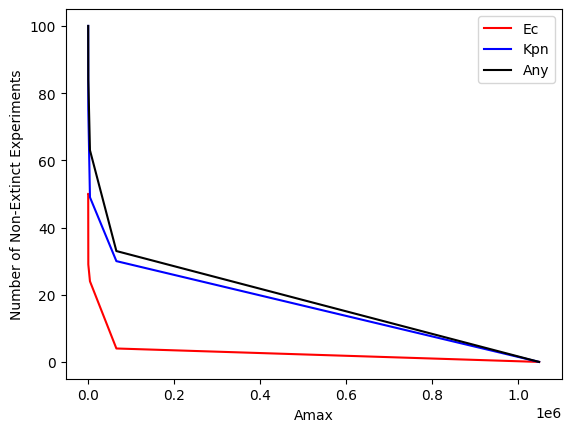

In [29]:

def plot_pairwiseStability(num_non_extinct0, num_non_extinct1, num_non_extinctAll, Amax_values):
    plt.plot(Amax_values, num_non_extinct0, label='Ec', color='red')
    plt.plot(Amax_values, num_non_extinct1, label='Kpn', color='blue')
    plt.plot(Amax_values, num_non_extinctAll, label='Any',color='black')
    plt.xlabel('Amax')
    plt.ylabel('Number of Non-Extinct Experiments')
    plt.legend()
    plt.show()



plot_pairwiseStability(num_non_extinct0, num_non_extinct1, num_non_extinctAll, Amax_values)